<a href="https://colab.research.google.com/github/erickbonas/projetofinal/blob/main/rascunho_analises_erick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"erickbonifaciobello","key":"83ea173a21a1480a84351e3b1e475891"}'}

In [ ]:
! pip install kaggle==1.5.6
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! mkdir dataset

In [ ]:
! kaggle competitions download -c fake-news-pair-classification-challenge -p '/content/dataset'

 49% 17.0M/34.6M [00:01<00:01, 12.9MB/s]
100% 34.6M/34.6M [00:01<00:00, 23.6MB/s]


In [ ]:
! unzip '/content/dataset/fake-news-pair-classification-challenge.zip' -d '/content/dataset'

Archive:  /content/dataset/fake-news-pair-classification-challenge.zip
  inflating: /content/dataset/sample_submission.csv  
  inflating: /content/dataset/test.csv  
  inflating: /content/dataset/train.csv  


In [ ]:
! pip install neattext

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import neattext as nt
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [ ]:
def formataTexto(text): 
    text = text.lower()
    text = nt.remove_stopwords(text)
    return text

In [ ]:
def frequencies(dataset, column):
    labels, counts = np.unique(dataset[column], return_counts=True)
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]
    
    (sns
     .barplot([l[:40] for l in labels], counts)
     .set_title(f'Occurrences for The {len(labels)} Classes in {column}'))
    plt.xticks(rotation=90)
    
    return labels, counts

In [ ]:
training = pd.read_csv('dataset/train.csv')
training = training.sample(n=50000)
training.head()

,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
319478,320114,12694,12687,药店有一种水，全是维生素，美白淡斑，抹一次能感觉皮肤的紧致！,68岁大妈无意间用了家中一物，一周美白淡斑和斑点说拜拜,"The pharmacy has a kind of water, all is vitam...",The 68-year-old unwittingly used one of the th...,unrelated
113478,113780,85682,85692,双旗币最新价格多少，哪个市场出手快！,双旗币的成交记录,"Double-flag the newest price how much, which m...",two-flag trading record.,unrelated
89160,89423,70941,70947,农村老奶奶治疗脚气偏方，3天根治10年脚气不复发,不管白发多凶，藿香正气水这样使，8分钟白发乌黑柔顺，不再染发,"Countryside Granny Treats Foot Biopsy, Treats ...","No matter how bad the white hair is, the Amoeb...",unrelated
232007,232492,139439,64399,柠檬水的多种喝法，每天一杯，美白又瘦身！,柠檬水就要这样喝减肥效果才好！美白又健康，不知不觉瘦下来,"Lemonade in a variety of ways to drink, a cup ...",Lemonade is like this drink to lose weight eff...,agreed
206926,207345,20037,130038,无籽葡萄与避孕药——密不可分？,健康｜无籽葡萄用避孕药培育？这些关于水果的谣言千万别信！,Seedless grapes and birth control pills - inse...,Healthy seedless grapes are nurtured by birth ...,disagreed


In [ ]:
test = pd.read_csv('dataset/test.csv')
test.head()

,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en
0,321187,167562,59521,萨拉赫人气爆棚!埃及总统大选未参选获百万选票 现任总统压力山大,辟谣！里昂官方否认费基尔加盟利物浦，难道是价格没谈拢？,egypt 's presidential election failed to win m...,Lyon! Lyon officials have denied that Felipe F...
1,321190,167564,91315,萨达姆被捕后告诫美国的一句话，发人深思,10大最让美国人相信的荒诞谣言，如蜥蜴人掌控着美国,A message from Saddam Hussein after he was cap...,The Top 10 Americans believe that the Lizard M...
2,321189,167563,167564,萨达姆此项计划没有此国破坏的话，美国还会对伊拉克发动战争吗,萨达姆被捕后告诫美国的一句话，发人深思,Will the United States wage war on Iraq withou...,A message from Saddam Hussein after he was cap...
3,321193,167564,160994,萨达姆被捕后告诫美国的一句话，发人深思,被绞刑处死的萨达姆是替身？他的此男人举动击破替身谣言！,A message from Saddam Hussein after he was cap...,The hanging Saddam is a surrogate? This man's ...
4,321191,167564,15084,萨达姆被捕后告诫美国的一句话，发人深思,中国川贝枇杷膏在美国受到热捧？纯属谣言！,A message from Saddam Hussein after he was cap...,Chinese loquat loquat plaster in America? Pure...


In [ ]:
#Aplica strip em todas as colunas do dataframe
training = training.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [ ]:
training = training.replace(r'^\s*$', np.nan, regex=True)
training[training.isna().any(axis=1)]

,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
291175,291779,34114,42543,纳斯达克推出数字货币交易所，手续费全免时代来临,NaN,Nasdaq launches digital currency exchange,_,agreed
242810,243368,32190,42543,治疗风湿累风湿的小妙招,NaN,a trick for rheumatism rheumatism,_,agreed


In [ ]:
training['label'].value_counts()

unrelated    219313
agreed        92973
disagreed      8266
Name: label, dtype: int64

In [ ]:
# Remove todos os NaN da tabela
training = training.dropna()
training['label'].value_counts()

unrelated    34180
agreed       14522
disagreed     1296
Name: label, dtype: int64

In [ ]:
(training['label'].values=='disagreed').sum()

1295

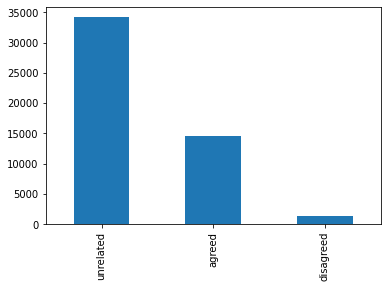

In [ ]:
training['label'].value_counts().plot.bar()

In [ ]:
training.to_csv('training.csv')
files.download('training.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
training['title1EnProcessado'] = training['title1_en'].apply(formataTexto)
training.head()

,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label,title1EnProcessado
0,0,0,1,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated,new old-age insurance benefits old people rura...
1,3,2,3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated,"""if come shenzhen, sooner later son come."" 10 ..."
2,1,2,4,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",GDP首超香港？深圳澄清：还差一点点……,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated,"""if come shenzhen, sooner later son come."" 10 ..."
3,2,2,5,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",去年深圳GDP首超香港？深圳统计局辟谣：还差611亿,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated,"""if come shenzhen, sooner later son come."" 10 ..."
4,9,6,7,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",吃了30年食用油才知道，一片大蒜轻松鉴别地沟油,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,agreed,"""how discriminate oil gutter oil means garlic."


In [ ]:

text = ' '.join(training['title1EnProcessado'].values)

wordcloudText = WordCloud(width = 1024, height = 800, background_color='black', min_font_size=10).generate(text)



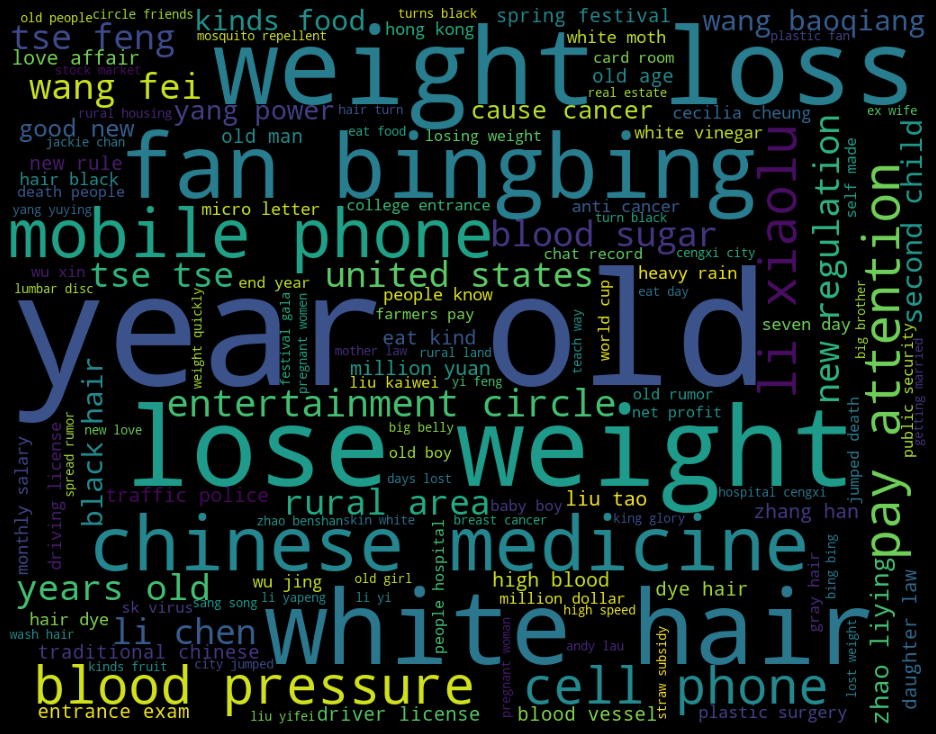

In [ ]:
plt.figure(figsize = (20, 10), facecolor = 'k')
plt.imshow(wordcloudText)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

In [ ]:
df_train, df_val = train_test_split(training[['title1_en', 'title2_en', 'label']], test_size=0.2, shuffle=True)
df_train

,title1_en,title2_en,label
115200,Because of many troublesome character and Li S...,"Once again, Li Tianyi's life was questioned be...",agreed
219732,Do you believe the 7 Great Prophecies of the F...,What are the future of the rural future? Where...,agreed
308138,Oncology expert real-time voice: anti-cancer a...,Dietetic cancer: how to eat the better fruits ...,unrelated
211018,"in spring, the body is dry and desquamated, an...","Body moisture rises in spring, adding it when ...",unrelated
275154,Do not dye the white hair! The starch is so us...,Don't ever dye your hair again. It's practical...,unrelated
...,...,...,...
60478,Jie Yuating in five luxury homes in the US: mo...,700 square meters! Jia Yuating in the beautifu...,unrelated
111775,It's so easy to locate someone's location. Ope...,"To know the exact location of the husband, ope...",agreed
75846,"Constipation 7 days, 1 month? Drinking them on...",Are your chopsticks causing cancer? Three tips...,unrelated
123692,zhou libo carries a maximum sentence of 41 yea...,"Zhou Libo was sentenced to 41 years in prison,...",unrelated


In [ ]:
x_train, x_val = df_train[['title1_en', 'title2_en']], df_val[['title1_en', 'title2_en']]
y_train, y_val = df_train['label'], df_val['label']
x_val

,title1_en,title2_en
292775,"Survival of the Jedi: Yes, Tencent agent for t...","""Survival of the Jedi"" national service line i..."
260634,"Mr Wang openly mocked Mr Ma! Mr Ma, come here ...",Wang Sicong micro- blog tore up Ma: Paypal cha...
99020,Liu Kaiwei issued a letter to accuse the derai...,"""The Power of the Phoenix"" issued a statement ..."
198526,It is said that the characteristics of the gir...,It is said that the characteristics of the gir...
45416,The Three Kingdoms rush to export advanced eng...,MADASHI 3000 Technical Migration? It's a rumou...
...,...,...
33074,"""Smiling A Smile"" 2 ""Shooting, Directing Team'...","When you're in the middle of a crisis, you can..."
290372,"Red dates and it bubble together, a cup every ...","You can turn white one time, and you can bleac..."
293498,"Green card holder, green card, no more than 3 ...","Feng Xiaogang satirizes the rubbish movie of ""..."
71818,the two sides did not reciprocate by restartin...,"Ofo sues anrennet, media benches and others fo..."


In [ ]:
features = 1024

encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',
                                        max_features=features),
                        StandardScaler(with_mean=False))

x_train_title1 = encoder.fit_transform(x_train['title1_en']).toarray()
x_val_title1 = encoder.transform(x_val['title1_en']).toarray()

x_train_title2 = encoder.fit_transform(x_train['title2_en']).toarray()
x_val_title2 = encoder.transform(x_val['title2_en']).toarray()

In [ ]:
label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_val = label_enc.transform(y_val)

In [ ]:
label_enc.classes_

array(['agreed', 'disagreed', 'unrelated'], dtype=object)

In [ ]:
x_train = np.concatenate((x_train_title1, x_train_title2), axis=1)
x_val = np.concatenate((x_val_title1, x_val_title2), axis=1)

In [ ]:
training = None
df_train = None
df_val = None
x_train_title1 = None
x_val_title1 = None
x_train_title2 = None
x_val_title2 = None

In [ ]:
x_train.shape

(39997, 1200)

In [ ]:
y_train.shape

(39997,)

In [ ]:
C_range = np.logspace(-3, 2, 5)

lm = LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=200, class_weight='balanced')

grid_values = {'penalty': ['l1','l2'], 'C': C_range}
grid_lm = GridSearchCV(lm, param_grid = grid_values, cv=3, scoring = 'accuracy', n_jobs = -1)

grid_lm.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.77827941e-02, 3.16227766e-01, 5.62341325e+00,
       1.00000000e+02]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
C_best = grid_lm.best_params_['C']
penalty_best = grid_lm.best_params_['penalty']
g = grid_lm 

In [ ]:
# Imprimindo os melhores parâmetros encontrados
print("Melhores parametros encontrados %s com score de %0.4f" % (grid_lm.best_params_, grid_lm.best_score_))

Melhores parametros encontrados {'C': 0.001, 'penalty': 'l1'} com score de 0.6949


In [ ]:
from sklearn import metrics
import seaborn as sns; sns.set()

def evaluate(y, p, probabilities, labels=None):
    # Cálculo das métricas de acerto.
    print('Accuracy:', metrics.accuracy_score(y, p).round(3))
    print('Accuracy (balanced):', metrics.balanced_accuracy_score(y, p).round(3))
    
    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)
    
    # Impressão dos gráficos.
    (plt
     .figure(figsize=(10, 8))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False)    

Accuracy: 0.697
Accuracy (balanced): 0.493


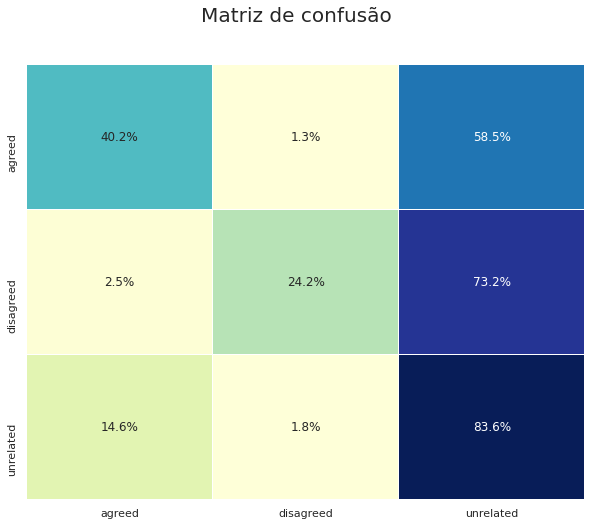

In [ ]:
evaluate(y_val, g.predict(x_val), g.predict_proba(x_val), labels=label_enc.classes_)

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(   
    random_state=0, 
    oob_score=True, 
    n_jobs=-1, 
    class_weight='balanced', 
    max_features=features
)

grid_clf_values = {'max_depth': [5, 10, 15], 'n_estimators': [150, 200]}
grid_clf = GridSearchCV(clf, param_grid = grid_clf_values, cv=3, scoring = 'balanced_accuracy', n_jobs = -1)

grid_clf.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=1024,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=True, random_state=0,
                                  

In [ ]:
# Imprimindo os melhores parâmetros encontrados
print("Melhores parametros encontrados %s com score de %0.4f" % (grid_clf.best_params_, grid_clf.best_score_))

Melhores parametros encontrados {'max_depth': 10, 'n_estimators': 150} com score de 0.5699


Accuracy: 0.372
Accuracy (balanced): 0.569


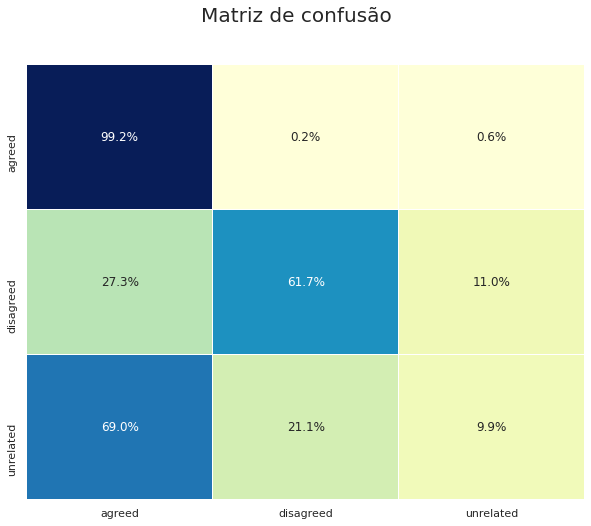

In [ ]:
evaluate(y_val, grid_clf.predict(x_val), grid_clf.predict_proba(x_val), labels=label_enc.classes_)

## Redes Neurais

In [ ]:
from keras.utils import np_utils
from keras.models import Sequential
from keras import Model
from keras.layers import Dense, Activation, Input, InputLayer, Dropout
from keras import optimizers, callbacks

In [ ]:
epochs = 20
batch_size = 128
input_shape = [features]

In [ ]:
y_ohe_train = np_utils.to_categorical(ye_train, num_classes=3)
y_ohe_val = np_utils.to_categorical(ye_val, num_classes=3)

In [ ]:
model = Sequential([
InputLayer((1024,)),
Dense(1024, activation="relu"),
Dense(256, activation = "relu"),
Dense(6, activation="softmax")
])

model.compile(optimizer='sgd',
loss='categorical_crossentropy',
# metrics=['accuracy'])
metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])

model.summary()